# Fama-French 3-Factor Model: MANGO Portfolio Analysis

## Objective
To analyze the MANGO portfolio's (MSFT, AAPL, NVDA, GOOGL, AMZN) returns by decomposing them into three systematic risk factors using the **Fama-French 3-Factor Model**. This model extends beyond the traditional CAPM to provide a deeper understanding of performance drivers.


1. **Factor Sensitivities:**
   - **Market Risk Premium (Mkt-RF)**: Exposure to overall market movements.
   - **SMB (Small Minus Big)**: Sensitivity to size factor (small-cap vs. large-cap).
   - **HML (High Minus Low)**: Sensitivity to value factor (value vs. growth stocks).

2. **Alpha (Intercept):**  
   - Measures the portfolio’s return **not explained** by the 3 factors.  
   - If alpha is statistically significant and positive, it may suggest skill or additional risk premia.

3. **R² (Goodness of Fit):**
   - Indicates how well the three factors explain the portfolio's return variation.
   - Higher R² implies a better fit.

---

- CAPM uses only the market factor.  
- The **Fama-French model** incorporates real-world effects like size and value, providing:
  - Better performance attribution.
  - Clarity on whether returns are **systematic** or **idiosyncratic**.
  - Insight into **factor tilts** in your portfolio (e.g. large-cap growth).

This project examines whether MANGO's performance can be explained by exposure to common market risk factors. If **alpha ≈ 0**, the portfolio’s returns are due to **factor exposures**. If **alpha > 0 (significant)**, it may indicate **true outperformance** or **model misspecification**.

## Model Equation

$$R_i - R_f = \alpha + \beta_m (R_m - R_f) + \beta_s \cdot SMB + \beta_h \cdot HML + \epsilon$$

Where:
- $R_i - R_f$: Excess return of the MANGO portfolio
- $R_m - R_f$: Market risk premium
- **SMB**: Small minus Big (size factor)
- **HML**: High minus Low (value factor)
- $\alpha$: Jensen’s Alpha
- $\beta_m, \beta_s, \beta_h$: Factor loadings



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


/var/folders/cf/py2r6m5s0z97pl9l1w028rlr0000gn/T/ipykernel_55359/1728591764.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(tickers, start=start, end=end)
[                       0%                       ]

Note: you may need to restart the kernel to use updated packages.


[*********************100%***********************]  5 of 5 completed


                            OLS Regression Results                            
Dep. Variable:           Excess_MANGO   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     286.7
Date:                Fri, 01 Aug 2025   Prob (F-statistic):           7.96e-80
Time:                        00:30:25   Log-Likelihood:                 913.05
No. Observations:                 249   AIC:                            -1818.
Df Residuals:                     245   BIC:                            -1804.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.237      0.2

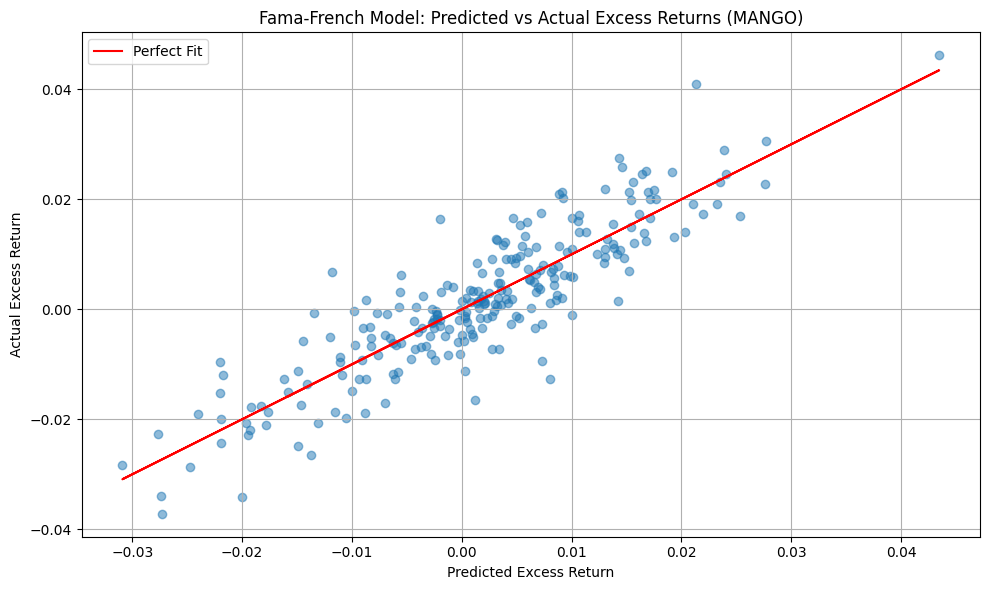

In [3]:
# Install required packages (only run once)
%pip install yfinance pandas statsmodels numpy requests zipfile36

# --- 1. Imports ---
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import zipfile
import io
import requests

# --- 2. Download Stock Data ---
tickers = ['MSFT', 'AAPL', 'NVDA', 'GOOGL', 'AMZN']
start = '2023-07-01'
end = '2024-07-01'

# Download data with full column structure
raw_data = yf.download(tickers, start=start, end=end)

# Handle MultiIndex (if multiple tickers)
if isinstance(raw_data.columns, pd.MultiIndex):
    data = raw_data['Close']
else:
    data = raw_data

# Calculate log returns
returns = np.log(data / data.shift(1)).dropna()

# Add equally weighted portfolio 'MANGO'
returns['MANGO'] = returns.mean(axis=1)


# --- 3. Download Fama-French 3 Factors (daily) ---
url = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip'
r = requests.get(url)
with zipfile.ZipFile(io.BytesIO(r.content)) as z:
    with z.open(z.namelist()[0]) as f:
        ff_factors = pd.read_csv(f, skiprows=4)

# --- 4. Clean Fama-French Data ---
ff_factors = ff_factors.rename(columns={'Unnamed: 0': 'Date'})
ff_factors = ff_factors[ff_factors['Date'].str.len() == 8]
ff_factors['Date'] = pd.to_datetime(ff_factors['Date'], format='%Y%m%d')
ff_factors = ff_factors.set_index('Date')
ff_factors = ff_factors[['Mkt-RF', 'SMB', 'HML', 'RF']].astype(float) / 100

# --- 5. Merge with Portfolio Returns ---
returns_ff = returns.merge(ff_factors, left_index=True, right_index=True)
returns_ff['Excess_MANGO'] = returns_ff['MANGO'] - returns_ff['RF']

# --- 6. Run Fama-French Regression ---
X = returns_ff[['Mkt-RF', 'SMB', 'HML']]
X = sm.add_constant(X)
y = returns_ff['Excess_MANGO']
ff_model = sm.OLS(y, X).fit()
print(ff_model.summary())

# --- 7. Plot Actual vs Predicted Returns ---
returns_ff['Predicted'] = ff_model.predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(returns_ff['Predicted'], returns_ff['Excess_MANGO'], alpha=0.5)
plt.plot(returns_ff['Predicted'], returns_ff['Predicted'], color='red', label='Perfect Fit')
plt.title('Fama-French Model: Predicted vs Actual Excess Returns (MANGO)')
plt.xlabel('Predicted Excess Return')
plt.ylabel('Actual Excess Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Model Fit

| Metric | Value | Interpretation |
|--------|--------|----------------|
| **R²** | 0.778 | 77.8% of return variance is explained by the 3 factors. Strong model fit. |
| **Adj. R²** | 0.776 | Adjusted for number of predictors. Consistently high. |
| **F-statistic** | 286.7 (p < 0.001) | The model is statistically significant. |

---

### Coefficients

| Factor | Coefficient | t-Stat | p-Value | Interpretation |
|--------|-------------|--------|---------|----------------|
| **α (Intercept)** | 0.0005 | 1.237 | 0.217 | Not statistically significant. No strong evidence of abnormal returns (alpha). |
| **Market (βₘ)** | 1.4818 | 25.800 | < 0.001 | MANGO has high market sensitivity. Acts like a high-beta portfolio. |
| **SMB (βₛ)** | -0.3692 | -5.939 | < 0.001 | Negative size exposure → Preference for large-cap stocks. |
| **HML (βₕ)** | -0.6672 | -9.880 | < 0.001 | Negative value exposure → Tilt toward growth stocks. |

---

### Insights

- The **MANGO portfolio behaves like a high-beta, large-cap, growth strategy**.
- Strong market dependence (β > 1).
- Negative SMB and HML exposures align with its composition (big tech, growth names).
- **No statistically significant alpha** → returns are well explained by common risk factors.

---

### Conclusion

The Fama-French model explains MANGO’s performance effectively. While there’s no strong alpha, the portfolio's return characteristics reflect a growth-tilted, large-cap strategy with elevated sensitivity to market movements.

## CAPM vs Fama-French 3-Factor Model: MANGO Portfolio

We compare two models of asset pricing applied to the MANGO portfolio:

### 1️⃣ Capital Asset Pricing Model (CAPM)


| Metric | Value | Interpretation |
|--------|--------|----------------|
| **Alpha (α)** | ~0.0006 | Statistically insignificant (p > 0.05) – No abnormal return |
| **Beta (β)** | ~1.495 | High sensitivity to market movements |
| **R²** | ~0.64 | 64% of the portfolio’s return variability is explained by the market |

**Key Takeaway**: CAPM shows the MANGO portfolio is highly correlated with market returns but does not generate significant alpha.

---

### 2️⃣ Fama-French 3-Factor Model

| Metric | Value | Interpretation |
|--------|--------|----------------|
| **Alpha (α)** | ~0.0005 | Still statistically insignificant |
| **Beta (Market)** | 1.482 | High market sensitivity (confirming CAPM result) |
| **SMB (Size)** | -0.369 | Tilt toward large-cap stocks |
| **HML (Value)** | -0.667 | Tilt toward growth stocks |
| **R²** | 0.778 | **Better model fit** – explains ~78% of return variability |

**Key Takeaway**: Fama-French improves model explanatory power and reveals **portfolio tilts** (large-cap, growth). Still, no evidence of alpha.

---

### Summary

| Model | R² | Alpha | Factor Exposure |
|-------|----|--------|-----------------|
| **CAPM** | ~0.64 | Not significant | Market only |
| **Fama-French** | ~0.78 | Not significant | Market, Size (-), Value (-) |

---

### Final Insight

> The Fama-French model better explains the MANGO portfolio's performance and reveals key style exposures. However, neither model indicates the presence of statistically significant alpha. MANGO behaves like a **high-beta, large-cap, growth-oriented portfolio**.
